In [3]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import random
import seaborn as sns

# Part 1: One-lane highway

In [18]:
class TrafficSimulation:

    def __init__(self, length=50, car_density=0.2, slow_down_prob=0.5, max_speed=5, change_prob = 0):
        '''
        Creates a 1-lane traffic simulation.

        Inputs:
            length (int) The number of cells in the road. Default: 50.
            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.
            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.
            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
        '''
        self.length = length
        self.car_density = car_density
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob
        self.num_lanes = 1                                  # used for visualization
        self.change_prob = 0                                # used for visualization

        # Track the time steps and total number of cars that passed the simulation
        # boundary to estimate average traffic flow.
        self.time_step = 0
        self.cumulative_traffic_flow = 0

        random_indexes = scipy.random.choice(
            range(self.length),
            size=int(round(car_density * self.length)),
            replace=False)
        self.state = -scipy.ones(self.length, dtype=int)    # -1 indicates empty cell
        self.state[random_indexes] = scipy.random.randint(
            0, self.max_speed + 1, size=len(random_indexes))

    def update(self):
        '''
        Advance one time step in the simulation.
        Periodic boundary condition holds.
        '''

        # Update car velocities.
        for i in range(self.length):
            if self.state[i] != -1:
                distance = 1  
                while self.state[(i + distance) % self.length] == -1:
                    distance += 1
                # Acceleration
                if self.state[i] < self.max_speed:
                    self.state[i] += 1
                # Deceleration
                if self.state[i] >= distance:
                    self.state[i] = distance - 1
                # Randomization
                if (self.state[i] > 0) and (scipy.random.uniform() < self.slow_down_prob):
                    self.state[i] -= 1

        # Move cars forward using their new velocities
        new_state = -scipy.ones(self.length, dtype=int)
        for i in range(self.length):
            if self.state[i] != -1:
                new_state[(i + self.state[i]) % self.length] = self.state[i]
        self.state = new_state

        # Update time and traffic flow
        # Counts cars that passed the boundary 
        self.time_step += 1
        for i in range(self.max_speed):
            if self.state[i] > i:
                self.cumulative_traffic_flow += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

In [168]:
# Simulate low traffic density to see free flowing traffic
# Simulate high traffic density to see traffic jams

car_densities = [0.1, 0.3]
for density in car_densities:
    sim = TrafficSimulation(car_density = density)
    print "{}-Lane-Model, density = {}".format(sim.num_lanes,density)
    for i in range(20):
        sim.update()
        sim.display()
    print "\n"

1-Lane-Model, density = 0.1
0....3....4.....................3..........2......
0.......3......5...................3..........3...
0...........4......4..................3..........3
0................5.....4.................3.......0
.1....................5....4................3....0
1.1......................3.....4...............3..
0..1.........................4......5...........1.
0...1.............................5......5......0.
.1....2...............................4.......5.0.
..1.....2..................................5...1.1
.2.1......2...................................30..
.0..1.......2.................................0.1.
2.1..1........2................................1..
.1..2..2.........3...............................2
..1..1...2...........4...........................0
1...2.1.....3............4........................
.1...1.1........4............4....................
...2..1..2...........5...........4................
.....2..2..2.............4............5...........
...

# Part 2: Multi-lane highways

In [186]:
class TrafficSimulation2:
    '''
    Creates a n-lane traffic simulation.
    (Only 2-lane model is fully functioning.)
    
    Inputs:
            length (int) The number of cells in the road. Default: 50.
            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.
            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.
            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
            num_lanes (int) The number of lanes on the road. Default: 2.
            change_prob (float) The probability that a car will randomly
                not change lanes when all conditions are met. Default: 0.7.
    '''
    def __init__(self, length=50, car_density=0.2, slow_down_prob=0.5, max_speed=5, 
                 num_lanes=2, change_prob = 0.7):

        self.length = length                  #length of the road
        self.car_density = car_density
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob

        self.time_step = 0
        self.cumulative_traffic_flow = 0
        
        self.num_lanes = num_lanes
        self.change_prob = change_prob

        # Creates a 2D array with i number of lanes and j number of cells (length)
        self.road = -scipy.ones((self.num_lanes, self.length), dtype = int)
        for i in range(num_lanes):
            for j in random.sample(range(int(self.length)),int(self.car_density*self.length)):
                self.road[i,j] = random.randint(0,max_speed)


    def occupied_ahead(self,i,j):
        ''' 
        Looks ahead in own lane. 
        Returns True if road is occupied ahead within range speed+1.
        '''
        gap = 0
        for cell in range(1, int(self.road[i,j] + 1)):
            while self.road[i, (j + 1 + gap) % self.length] == -1:
                gap += 1
        if gap < self.road[i,j]+1:
            return True
        else: 
            return False

    def free_ahead_other(self, i,j):
        ''' 
        Looks ahead in other lane. 
        Returns True if road is free ahead within speed+1.
        '''
        gap_other = -1
        for cell in range(1, int(self.road[i,j] + 1)):
            while self.road[i-1, (j + 1 + gap_other) % self.length] == -1:
                gap_other += 1
        if gap_other < self.road[i,j]:
            return True
        else:
            return False
            
    def free_behind(self,i,j):
        ''' 
        Looks behind in other lane. 
        Returns True if road is free behind within max_speed.
        '''
        gap_behind = -1
        for cell in range(1, self.max_speed+1):
            while self.road[i-1, (j - 1 - gap_behind) % self.length] == -1:
                gap_behind += 1
        if gap_behind > self.max_speed:
            return True
        else:
            return False

    def rand_change(self):
        ''' 
        Adds stochasticity to lane changing.
        Returns True if random number falls within changing probability.
        '''
        if scipy.random.uniform() < self.change_prob:
            return True
        else:
            return False


    def change_lanes(self,i,j):
        ''' 
        Checks methods above for meeting rule conditions.
        Returns True if all conditions are met.
        '''
    # if all conditions evaluate to True change lanes
        if self.occupied_ahead(i, j):
            if self.free_ahead_other(i,j):
                if self.free_behind(i,j):
                    if self.rand_change():
                        return True
        else:
            return False


    def update(self):
        ''' 
        Advance one time step in the simulation, includes switching lanes.
        Periodic boundary condition holds.
        '''
        # Switch lanes
        for i in range(self.num_lanes):
            for j in range(self.length):
                if self.change_lanes(i,j) == True:
                    # test lane switches
                    # print("car {} in lane {} switching".format(j, i))
                    self.road[i-1, j] = self.road[i,j]

        # Update velocities
        for i in range(self.num_lanes):
            for j in range(self.length):
                if self.road[i,j] != -1:
                    distance = 1
                    while self.road[i, (j+distance) %self.length] == -1:
                        distance += 1
                    #Acceleration
                    if self.road[i,j] < self.max_speed:
                        self.road[i,j] += 1
                    #Deceleration
                    if self.road[i,j] >= distance:
                        self.road[i,j] = distance-1
                    #Randomization
                    if (self.road[i,j] > 0) and (scipy.random.uniform() < self.slow_down_prob):
                        self.road[i,j] -= 1

        # Move cars
        new_road = -scipy.ones((self.num_lanes, self.length), dtype=int)
        for i in range(self.num_lanes):
            for j in range(self.length):
                if self.road[i,j] != -1:
                    new_road[i, (j + self.road[i,j]) % self.length] = self.road[i,j]
        self.road = new_road

        # Update time and traffic flow
        # Counts cars that passed the boundary 
        self.time_step += 1
        for i in range(self.num_lanes):
            for j in range(self.max_speed):
                if self.road[i, j] > j:
                    self.cumulative_traffic_flow += 1    

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for lane in range(self.num_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.road[lane]))

        if self.num_lanes > 1:
            print "\n"
            

In [174]:
car_densities = [0.1, 0.3]
for density in car_densities:
    sim = TrafficSimulation2(car_density = density)
    print "{}-Lane-Model, density = {}".format(sim.num_lanes,density)
    for i in range(10):
        sim.update()
        sim.display()
    print "\n"

2-Lane-Model, density = 0.1
..0.1.........................5....3.....10....4..
.....3....4....................4..........2.0.....


3..1.1...........................3....3..0.1......
........3......5..............0....4.....0.1.1....


.1.0..1.......................0.....3..1.0..1.....
............4.......5..........1.......4.0..1.1...


.0..1...2.....................0.......2.10...1....
...0.............5.......5....0.1.......1.1..1..2.


.0...1.....3................3..1.......10.1...1...
2...1.................5.....3.0..1......0..1...2..


.0....1........4.............1..1......00..1...1..
..2...2....................5.1.1..1.....0...1....2


..1.....2..........4..........1...2....00...1...1.
.2...3...3.................0..1..2.1....0.....2...


...1.......3............5..0....2...2..0.1...1...1
...2....3...3...............1...20..1....1......2.


1...1..........4.........1.0......2..1.0..1...1...
2....2....2.....4.........2..1..00....2....2......


.1...1..............5.....10........

# Visualization Plots

In [63]:
def visualize(simulation, densities = np.linspace(0,1,50)):
    '''
    Visualizes the an errorbar plot for 50 simulations and 50 densities,
    with densities on the x-axis and flow rates on the y-axis.
    '''
    mean_flows = []
    std_flows = []
    
    # Colette helped me with the visualization, by showing me how to change my densities
    # to the current version to make it fit in the for loop.
    
    for dens in densities:
        flows = []
        for j in range(50):
            sim = simulation(car_density=dens)
            for i in range(100):
                    sim.update()
            avg_flow = sim.cumulative_traffic_flow / float(sim.time_step)
            flows.append(avg_flow)
        mean_flows.append(np.mean(flows) / float(sim.num_lanes))
        std_flows.append(np.std(flows))
    
    print ("Maximum traffic flow of", max(mean_flows), 
          "is reached at density:", densities[mean_flows.index(max(mean_flows))])
    
    plt.errorbar(scipy.linspace(0,1,50), mean_flows, xerr=0, yerr= 1.96*np.array(std_flows))
    plt.title('{} Lane Model: Traffic Flow per Density'.format(sim.num_lanes))
    plt.ylabel('Traffic Flow (car pass per time step)')
    plt.xlabel('Density (cars per site)')
    plt.ylim((-0.05, 0.55))
    plt.show()
    
    return mean_flows


('Maximum traffic flow of', 0.40360000000000001, 'is reached at density:', 0.1020408163265306)


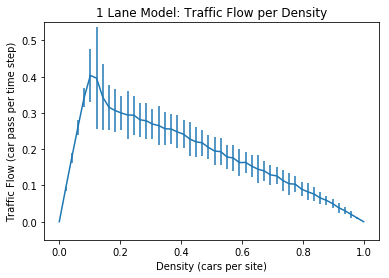

In [240]:
mean_flows = visualize(TrafficSimulation)

('Maximum traffic flow of', 0.27479999999999999, 'is reached at density:', 0.081632653061224483)


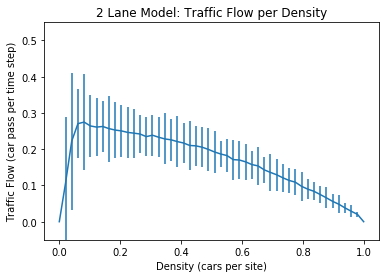

In [241]:
mean_flows2 = visualize(TrafficSimulation2)

In [231]:
print mean_flows[5] #density = 0.10
print mean_flows2[5]

0.397
0.271


# Stretch Goal: Driving Behavior

In [37]:
def visualize2(simulation, densities = np.linspace(0,1,50), slow_down = 0, change = 0):
    '''
    Visualizes the an errorbar plot for 50 simulations and 50 densities,
    with densities on the x-axis and flow rates on the y-axis.
    '''
    mean_flows = []
    std_flows = []
    
    # Colette helped me with the visualization, by showing me how to change my densities
    # to the current version to make it fit in the for loop.
    
    for dens in densities:
        flows = []
        for j in range(50):
            sim = simulation(car_density=dens, slow_down_prob = slow_down, change_prob = change)
            for i in range(100):
                    sim.update()
            avg_flow = sim.cumulative_traffic_flow / float(sim.time_step)
            flows.append(avg_flow)
        mean_flows.append(np.mean(flows) / float(sim.num_lanes))
        std_flows.append(np.std(flows))
    
    print ("Maximum traffic flow of", max(mean_flows), 
          "is reached at density:", densities[mean_flows.index(max(mean_flows))])
    
    plt.errorbar(scipy.linspace(0,1,50), mean_flows, xerr=0, yerr= 1.96*np.array(std_flows))
    plt.title('{} Lane Model: Traffic Flow per Density \n slow down probability: {}, lane change probability: {}'.format(sim.num_lanes, slow_down, change))
    plt.ylabel('Traffic Flow (car pass per time step)')
    plt.xlabel('Density (cars per site)')
    plt.ylim((-0.05, 1))
    plt.show()
    
    return mean_flows

('Maximum traffic flow of', 0.12840000000000001, 'is reached at density:', 0.040816326530612242)


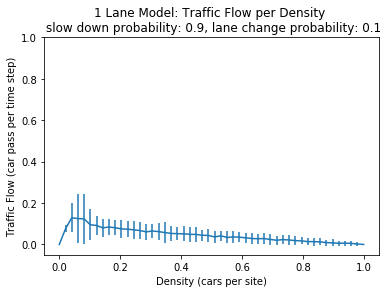

In [43]:
mean_flows3a = visualize2(TrafficSimulation, slow_down = 0.9, change = 0.1)

('Maximum traffic flow of', 0.12530000000000002, 'is reached at density:', 0.040816326530612242)


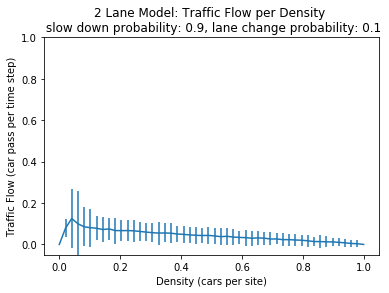

In [44]:
mean_flows3b = visualize2(TrafficSimulation2, slow_down = 0.9, change = 0.1)

('Maximum traffic flow of', 0.40820000000000001, 'is reached at density:', 0.12244897959183673)


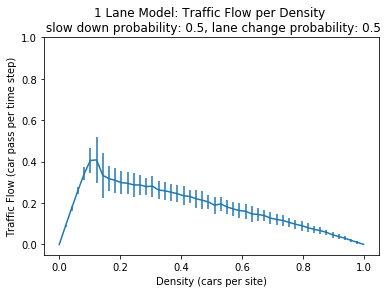

In [45]:
mean_flows4a = visualize2(TrafficSimulation, slow_down = 0.5, change = 0.5)

('Maximum traffic flow of', 0.29469999999999996, 'is reached at density:', 0.081632653061224483)


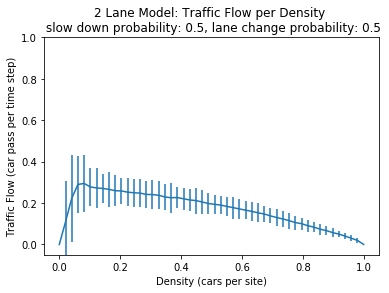

In [47]:
mean_flows4b = visualize2(TrafficSimulation2, slow_down = 0.5, change = 0.5)

('Maximum traffic flow of', 0.70599999999999996, 'is reached at density:', 0.16326530612244897)


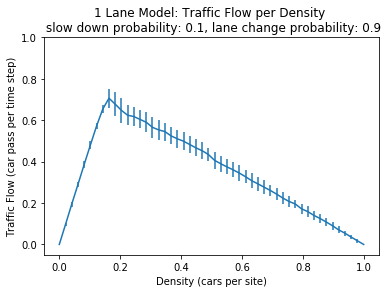

In [48]:
mean_flows5a = visualize2(TrafficSimulation, slow_down = 0.1, change = 0.9)

('Maximum traffic flow of', 0.58389999999999997, 'is reached at density:', 0.14285714285714285)


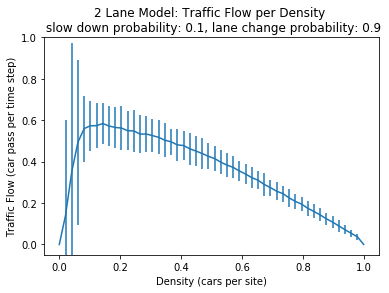

In [49]:
mean_flows5b = visualize2(TrafficSimulation2, slow_down = 0.1, change = 0.9)

# Autonomous Cars

In [55]:
class TrafficSimulation3:
    '''
    Addition to update rule: 
    speed up +1 if distance to the next car is larger than current speed
    speed up +1 if speed of next car is equal or larger to current speed
    
    Creates a n-lane traffic simulation.
    (Only 2-lane model is fully functioning.)
    
    Inputs:
            length (int) The number of cells in the road. Default: 50.
            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.
            slow_down_prob (float) The probability that a car will randomly
              slow down by 1 during an update step. Default: 0.5.
            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
            num_lanes (int) The number of lanes on the road. Default: 2.
            change_prob (float) The probability that a car will randomly
                not change lanes when all conditions are met. Default: 0.7.
    '''
    def __init__(self, length=50, car_density=0.2, slow_down_prob=0.5, max_speed=5, 
                 num_lanes=2, change_prob = 0.7):

        self.length = length                  #length of the road
        self.car_density = car_density
        self.max_speed = max_speed
        self.slow_down_prob = slow_down_prob

        self.time_step = 0
        self.cumulative_traffic_flow = 0
        
        self.num_lanes = num_lanes
        self.change_prob = change_prob

        # Creates a 2D array with i number of lanes and j number of cells (length)
        self.road = -scipy.ones((self.num_lanes, self.length), dtype = int)
        for i in range(num_lanes):
            for j in random.sample(range(int(self.length)),int(self.car_density*self.length)):
                self.road[i,j] = random.randint(0,max_speed)


    def occupied_ahead(self,i,j):
        ''' 
        Looks ahead in own lane. 
        Returns True if road is occupied ahead within range speed+1.
        '''
        gap = 0
        for cell in range(1, int(self.road[i,j] + 1)):
            while self.road[i, (j + 1 + gap) % self.length] == -1:
                gap += 1
        if gap < self.road[i,j]+1:
            return True
        else: 
            return False

    def free_ahead_other(self, i,j):
        ''' 
        Looks ahead in other lane. 
        Returns True if road is free ahead within speed+1.
        '''
        gap_other = -1
        for cell in range(1, int(self.road[i,j] + 1)):
            while self.road[i-1, (j + 1 + gap_other) % self.length] == -1:
                gap_other += 1
        if gap_other < self.road[i,j]:
            return True
        else:
            return False
            
    def free_behind(self,i,j):
        ''' 
        Looks behind in other lane. 
        Returns True if road is free behind within max_speed.
        '''
        gap_behind = -1
        for cell in range(1, self.max_speed+1):
            while self.road[i-1, (j - 1 - gap_behind) % self.length] == -1:
                gap_behind += 1
        if gap_behind > self.max_speed:
            return True
        else:
            return False

    def rand_change(self):
        ''' 
        Adds stochasticity to lane changing.
        Returns True if random number falls within changing probability.
        '''
        if scipy.random.uniform() < self.change_prob:
            return True
        else:
            return False


    def change_lanes(self,i,j):
        ''' 
        Checks methods above for meeting rule conditions.
        Returns True if all conditions are met.
        '''
    # if all conditions evaluate to True change lanes
        if self.occupied_ahead(i, j):
            if self.free_ahead_other(i,j):
                if self.free_behind(i,j):
                    if self.rand_change():
                        return True
        else:
            return False


    def update(self):
        ''' 
        Advance one time step in the simulation, includes switching lanes.
        Periodic boundary condition holds.
        '''
        # Switch lanes
        for i in range(self.num_lanes):
            for j in range(self.length):
                if self.change_lanes(i,j) == True:
                    # test lane switches
                    # print("car {} in lane {} switching".format(j, i))
                    self.road[i-1, j] = self.road[i,j]

        # Update velocities
        for i in range(self.num_lanes):
            for j in range(self.length):
                if self.road[i,j] != -1:
                    distance = 1
                    while self.road[i, (j+distance) %self.length] == -1:
                        distance += 1
                    #Acceleration
                    if self.road[i,j] < self.max_speed:
                        self.road[i,j] += 1
                    #Deceleration
                    if self.road[i,j] >= distance:
                        self.road[i,j] = distance-1
                    #Randomization
                    if (self.road[i,j] > 0) and (scipy.random.uniform() < self.slow_down_prob):
                        self.road[i,j] -= 1
                        
                    #Speed up
                    if distance > self.road[i,j]:
                        self.road[i,j] += 1
                    elif self.road[i,(j+distance)%self.length] >= self.road[i,j]:
                        self.road[i,j] += 1

        # Move cars
        new_road = -scipy.ones((self.num_lanes, self.length), dtype=int)
        for i in range(self.num_lanes):
            for j in range(self.length):
                if self.road[i,j] != -1:
                    new_road[i, (j + self.road[i,j]) % self.length] = self.road[i,j]
        self.road = new_road

        # Update time and traffic flow
        # Counts cars that passed the boundary 
        self.time_step += 1
        for i in range(self.num_lanes):
            for j in range(self.max_speed):
                if self.road[i, j] > j:
                    self.cumulative_traffic_flow += 1    

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        for lane in range(self.num_lanes):
            print(''.join('.' if x == -1 else str(x) for x in self.road[lane]))

        if self.num_lanes > 1:
            print "\n"
            

In [61]:
car_densities = [0.1, 0.3]
for density in car_densities:
    sim = TrafficSimulation3(car_density = density)
    print "{}-Lane-Model2, density = {}".format(sim.num_lanes,density)
    for i in range(10):
        sim.update()
        sim.display()
    print "\n"

2-Lane-Model2, density = 0.1
...........1..............5.......5..2.2.2........
31.......2.1.......................5.....2........


..........1..2..................6...2..21...3.....
.1..3......2..3....................1....5....4....


.............3..3...................4..31.2......5
.6..3...4....2....4...................3.....4.....


.....6..........3....5................2.11...3....
....3..3.....5..3.......6.............2...4......5


.....1.....6.........5.....6...........1.1..3....4
....5..3...4....3....5.........7..........4....5..


.....6.2..........7.......5.......7.....1...3....5
...6..2...3.....5...4......6..........7.......4...


.....6.2...4..............8.....6.......6..3....4.
..6..2....4...4....3......6.......7...4.......8...


...5..1...3......6..............6......7...3....5.
..6..3...4...3.....5....5.......6....3.....5......


..4...3..3....4........6..............6....4....5.
.....3..3...3.....5.....5.....6......5...4......5.


..4..3...3...4......6........6.....

('Maximum traffic flow of', 1.0, 'is reached at density:', 1.0)


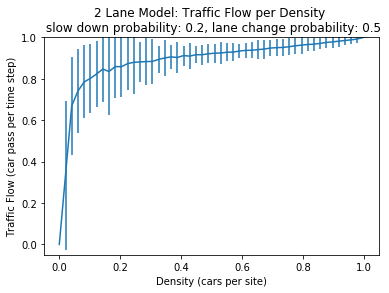

In [62]:
mean_flows6b = visualize2(TrafficSimulation3, slow_down = 0.2, change = 0.5)